<a href="https://colab.research.google.com/github/zeeamber/CNN_Melanoma_Prediction/blob/main/CNN_Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Reading data

In [1]:
# I have uploaded the zip data file in mounted driver. Now unzipping it.
!unzip /content/drive/MyDrive/ML_Datasets/CNN_assignment.zip > /dev/null

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.regularizers import l2

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Loading Dataset

In [5]:
# Defining parameters for the loader
batch_size = 32
img_size = (180, 180)

In [6]:
train_ds, validate_ds = image_dataset_from_directory(data_dir_train, batch_size= batch_size, image_size= img_size, seed= 123, validation_split= 0.20, subset= "both", label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [7]:
test_ds = image_dataset_from_directory(data_dir_test, batch_size= batch_size, image_size= img_size, seed= 123, label_mode='categorical')

Found 118 files belonging to 9 classes.


In [8]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data visualization

In [66]:
for image_batch, labels_batch in train_ds:
  print("Image batch shape", image_batch.shape)
  print("Labels batch shape", labels_batch.shape)
  break

Image batch shape (32, 180, 180, 3)
Labels batch shape (32, 9)


Here batch size is 32 as we specified earlier.
Each image is of dimention 180 X 180 X 3.
Labels batch represent the labels of images within a batch.

In [70]:
# Let's get some idea about distribution of images across labels.
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'Frequency'])

df = class_distribution_count(data_dir_train)
df

,Class,Frequency
0,vascular lesion,139
1,squamous cell carcinoma,181
2,seborrheic keratosis,77
3,pigmented benign keratosis,462
4,actinic keratosis,114
5,nevus,357
6,basal cell carcinoma,376
7,dermatofibroma,95
8,melanoma,438


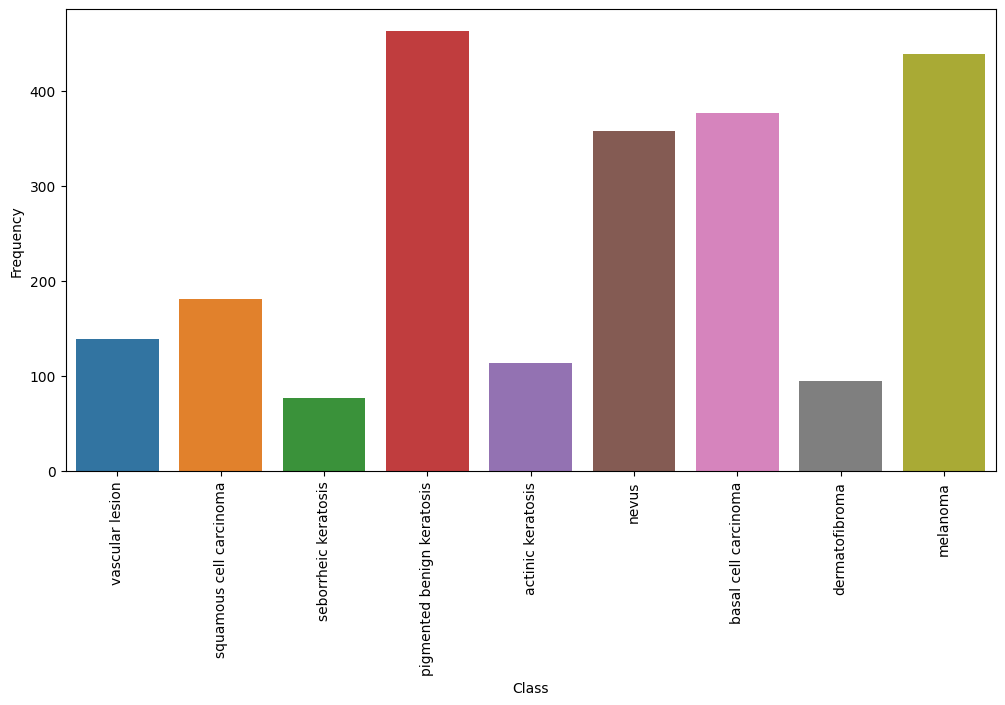

In [72]:
# Visualize Class distribution

plt.figure(figsize = (12, 6))
g = sns.barplot(x= 'Class', y= "Frequency", data= df)
plt.xticks(rotation = 90)
plt.show()


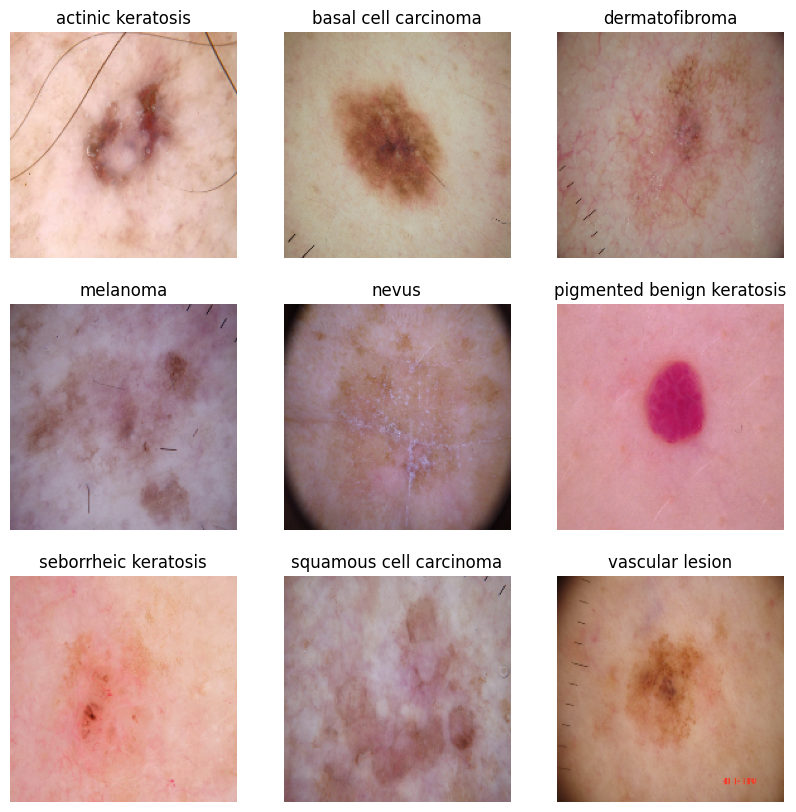

In [85]:
# Visualizing images from each class
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[i][i], 1))
    for images, labels in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.title(class_names[np.where(labels.numpy()[i]==1)[0][0]])
        plt.axis('off')


#### Configuring dataset for performance

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [87]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validate_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating first model

#### Standardizing data

The RGB channel values are in the [0, 255] range. We will standardize this to range [0, 1]

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))

#### Building model

In [90]:
# Defining Topology
model1 = Sequential()
model1.add(normalization_layer)

model1.add(layers.Conv2D(32, (3, 3), activation= "relu"))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(64, (3, 3), activation= "relu"))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(128, (3, 3), activation= "relu"))

model1.add(layers.Flatten())

model1.add(layers.Dense(128, activation= "relu"))
model1.add(layers.Dense(9, activation= "softmax"))

In [91]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 41, 41, 128)      

In [96]:
# Compiling the model
model1.compile(optimizer= "adam", loss= tf.keras.losses.CategoricalCrossentropy(), metrics= ["accuracy"])

In [97]:
# Training model
epochs = 20
history = model1.fit(train_ds, epochs= epochs, validation_data= val_ds)

Epoch 1/20
56/56 [==============================] - 5s 54ms/step - loss: 2.5952 - accuracy: 0.2333 - val_loss: 1.8174 - val_accuracy: 0.3490
Epoch 2/20
56/56 [==============================] - 2s 37ms/step - loss: 1.7235 - accuracy: 0.3767 - val_loss: 1.5989 - val_accuracy: 0.4899
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.5316 - accuracy: 0.4654 - val_loss: 1.4459 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4554 - accuracy: 0.4922 - val_loss: 1.4502 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 2s 37ms/step - loss: 1.3389 - accuracy: 0.5218 - val_loss: 1.3794 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 2s 37ms/step - loss: 1.2449 - accuracy: 0.5519 - val_loss: 1.4475 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 2s 37ms/step - loss: 1.2350 - accuracy: 0.5675 - val_loss: 1.6082 - val_accuracy: 0.4899
Epoch 8/20
56

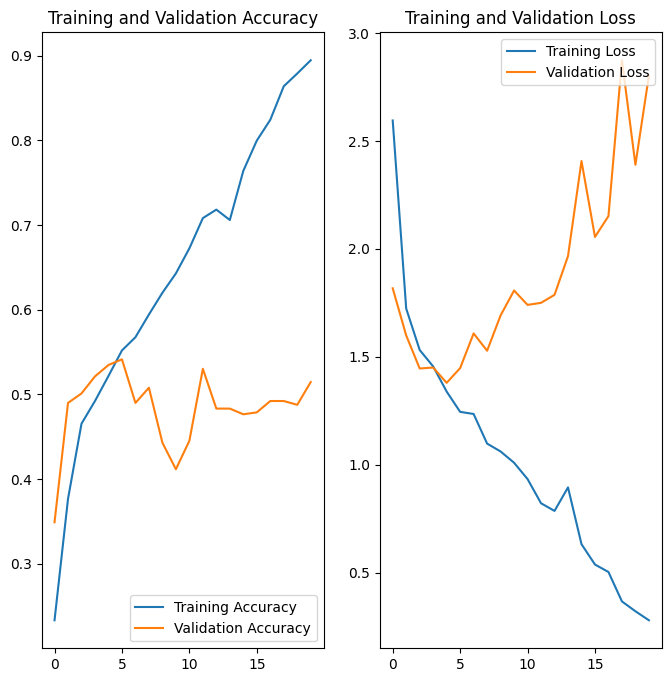

In [98]:
# Visualizing train result

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Our first model has achieved a training accuracy of 89% but it's accuracy on validation dataset is just 51%, which clearly indicates an overfit.

## Creating model 2 with Batch Normalisation

In [99]:
# Defining Topology
model2 = Sequential()
model2.add(normalization_layer)

model2.add(layers.Conv2D(32, (3, 3), activation= "relu"))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation= "relu"))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation= "relu"))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())

model2.add(layers.Dense(128, activation= "relu"))
model2.add(layers.Dense(9, activation= "softmax"))

In [100]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_20 (Ba  (None, 178, 178, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_21 (Ba  (None, 87, 87, 64)       

In [101]:
# Compiling the model
model2.compile(optimizer= "adam", loss= tf.keras.losses.CategoricalCrossentropy(), metrics= ["accuracy"])

In [102]:
# Training model
history = model2.fit(train_ds, epochs= epochs, validation_data= val_ds)

Epoch 1/20
56/56 [==============================] - 5s 47ms/step - loss: 4.7452 - accuracy: 0.3008 - val_loss: 31.9596 - val_accuracy: 0.0492
Epoch 2/20
56/56 [==============================] - 2s 44ms/step - loss: 1.9830 - accuracy: 0.3996 - val_loss: 56.1421 - val_accuracy: 0.0492
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.7028 - accuracy: 0.4330 - val_loss: 33.4491 - val_accuracy: 0.0403
Epoch 4/20
56/56 [==============================] - 2s 44ms/step - loss: 1.5146 - accuracy: 0.4922 - val_loss: 21.4460 - val_accuracy: 0.1119
Epoch 5/20
56/56 [==============================] - 2s 44ms/step - loss: 1.3893 - accuracy: 0.5530 - val_loss: 16.5095 - val_accuracy: 0.1588
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2754 - accuracy: 0.5765 - val_loss: 9.0915 - val_accuracy: 0.1298
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.1159 - accuracy: 0.6194 - val_loss: 9.3536 - val_accuracy: 0.2304
Epoch 8/

With Batch Normalization also the model is overfitting.

## Creating model 3 with dropout layers

In [103]:
# Defining Topology
model3 = Sequential()
model3.add(normalization_layer)
model3.add(layers.Conv2D(32, (3, 3), activation= "relu"))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.25))

model3.add(layers.Conv2D(64, (3, 3), activation= "relu"))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.25))

model3.add(layers.Conv2D(128, (3, 3), activation= "relu"))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.25))

model3.add(layers.Flatten())

model3.add(layers.Dense(128, activation= "relu"))
model3.add(layers.Dense(9, activation= "softmax"))

In [104]:
model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                               

In [105]:
# Compiling the model
model3.compile(optimizer= "adam", loss= tf.keras.losses.CategoricalCrossentropy(), metrics= ["accuracy"])

In [106]:
# Training model
history = model3.fit(train_ds, epochs= epochs, validation_data= val_ds)


Epoch 1/20
56/56 [==============================] - 5s 55ms/step - loss: 2.2871 - accuracy: 0.1948 - val_loss: 2.0348 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 3s 51ms/step - loss: 2.0212 - accuracy: 0.2176 - val_loss: 1.9438 - val_accuracy: 0.2819
Epoch 3/20
56/56 [==============================] - 3s 51ms/step - loss: 1.8735 - accuracy: 0.2919 - val_loss: 1.8023 - val_accuracy: 0.3714
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.6984 - accuracy: 0.3689 - val_loss: 1.6657 - val_accuracy: 0.4340
Epoch 5/20
56/56 [==============================] - 3s 52ms/step - loss: 1.6442 - accuracy: 0.4001 - val_loss: 1.8246 - val_accuracy: 0.3110
Epoch 6/20
56/56 [==============================] - 3s 51ms/step - loss: 1.6230 - accuracy: 0.4057 - val_loss: 1.6987 - val_accuracy: 0.3423
Epoch 7/20
56/56 [==============================] - 3s 51ms/step - loss: 1.5870 - accuracy: 0.4347 - val_loss: 1.6350 - val_accuracy: 0.4944
Epoch 8/20
56

Using the dropout layers has reduced the difference in accuracy between train and validation datasets. But still the differce is significant and model is overfitting. Also the dropout layers have taken down train accuracy significantly.

### Creating model 4 with L2 Reguralization

In [107]:
# Defining Topology
model4 = Sequential()
model4.add(normalization_layer)
model4.add(layers.Conv2D(32, (3, 3), activation= "relu"))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(64, (3, 3), activation= "relu"))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(128, (3, 3), activation= "relu"))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(128, (3, 3), activation= "relu"))
model4.add(layers.BatchNormalization())

model4.add(layers.Flatten())
model4.add(layers.Dense(128, kernel_regularizer=l2(0.001), activation= "relu"))
model4.add(layers.Dense(9, activation= "softmax"))

In [108]:
model4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_23 (Ba  (None, 178, 178, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_24 (Ba  (None, 87, 87, 64)      

In [109]:
# Compiling the model
model4.compile(optimizer= "adam", loss= tf.keras.losses.CategoricalCrossentropy(), metrics= ["accuracy"])

In [110]:
# Training model
history = model4.fit(train_ds, epochs= epochs, validation_data= val_ds)

Epoch 1/20
56/56 [==============================] - 6s 50ms/step - loss: 6.4465 - accuracy: 0.3292 - val_loss: 18.3151 - val_accuracy: 0.0537
Epoch 2/20
56/56 [==============================] - 3s 45ms/step - loss: 4.0198 - accuracy: 0.4023 - val_loss: 26.6211 - val_accuracy: 0.0470
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 3.4032 - accuracy: 0.4431 - val_loss: 16.9392 - val_accuracy: 0.1588
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 2.5858 - accuracy: 0.4738 - val_loss: 8.6028 - val_accuracy: 0.1342
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 2.3229 - accuracy: 0.5329 - val_loss: 9.4062 - val_accuracy: 0.1544
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 2.0295 - accuracy: 0.5748 - val_loss: 4.3241 - val_accuracy: 0.2975
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.7185 - accuracy: 0.6451 - val_loss: 5.8536 - val_accuracy: 0.2461
Epoch 8/20

With L2 Regularization, training accuracy improved but again model is overfitting.

### Addressing class imbalance in dataset

We have seen in Data Visualization section that number of samples are not evenly distributed across the classes.

We will use augmentation to add artificial samples to non-dominant classes to curb class imbalance.



In [10]:
!pip install Augmentor

In [11]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples to each class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E8DC1589BD0>: 100%|██████████| 500/500 [00:04<00:00, 119.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8DC158BA60>: 100%|██████████| 500/500 [00:03<00:00, 128.43 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8DC15F1270>: 100%|██████████| 500/500 [00:04<00:00, 103.60 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E8DC1592B00>: 100%|██████████| 500/500 [00:20<00:00, 24.14 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8DFA93EF80>: 100%|██████████| 500/500 [00:16<00:00, 30.71 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8DFA93F610>: 100%|██████████| 500/500 [00:03<00:00, 129.80 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E8DC15A6EC0>: 100%|██████████| 500/500 [00:08<00:00, 60.93 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8DFA9ED5D0>: 100%|██████████| 500/500 [00:03<00:00, 131.71 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8DC156D5A0>: 100%|██████████| 500/500 [00:03<00:00, 132.10 Samples/s]


In [12]:
# Creating train and validation data again after augmentation
train_ds_augmented, validate_ds_augmented = image_dataset_from_directory(data_dir_train, batch_size= batch_size, image_size= img_size, seed= 123, validation_split= 0.20, subset= "both", label_mode='categorical')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Using 1347 files for validation.


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_augmented = train_ds_augmented.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validate_ds_augmented = validate_ds_augmented.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# Creating final model
model5 = Sequential()
model5.add(normalization_layer)

model5.add(layers.Conv2D(32, (3, 3), activation= "relu"))
model5.add(layers.MaxPooling2D((2, 2)))

model5.add(layers.Conv2D(64, (3, 3), activation= "relu"))
model5.add(layers.MaxPooling2D((2, 2)))

model5.add(layers.Conv2D(128, (3, 3), activation= "relu"))
model5.add(layers.MaxPooling2D((2, 2)))

model5.add(layers.Dropout(0.5))

model5.add(layers.Flatten())

model5.add(layers.Dense(128, activation= "relu"))

model5.add(layers.Dropout(0.25))

model5.add(layers.Dense(9, activation= "softmax"))

In [15]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [16]:
# Compiling the model
model5.compile(optimizer= "adam", loss= tf.keras.losses.CategoricalCrossentropy(), metrics= ["accuracy"])

In [17]:
# Training model
epochs = 30
history = model5.fit(train_ds_augmented, epochs= epochs, validation_data= validate_ds_augmented)

Epoch 1/30
169/169 [==============================] - 24s 31ms/step - loss: 1.8720 - accuracy: 0.2717 - val_loss: 1.4385 - val_accuracy: 0.4655
Epoch 2/30
169/169 [==============================] - 3s 20ms/step - loss: 1.4881 - accuracy: 0.4360 - val_loss: 1.3482 - val_accuracy: 0.4907
Epoch 3/30
169/169 [==============================] - 3s 20ms/step - loss: 1.2852 - accuracy: 0.5139 - val_loss: 1.2969 - val_accuracy: 0.5189
Epoch 4/30
169/169 [==============================] - 3s 20ms/step - loss: 1.1409 - accuracy: 0.5814 - val_loss: 1.1261 - val_accuracy: 0.6021
Epoch 5/30
169/169 [==============================] - 3s 20ms/step - loss: 1.0539 - accuracy: 0.6096 - val_loss: 0.9785 - val_accuracy: 0.6399
Epoch 6/30
169/169 [==============================] - 3s 20ms/step - loss: 0.9133 - accuracy: 0.6626 - val_loss: 0.9004 - val_accuracy: 0.6800
Epoch 7/30
169/169 [==============================] - 3s 20ms/step - loss: 0.7832 - accuracy: 0.7179 - val_loss: 0.8496 - val_accuracy: 0.711

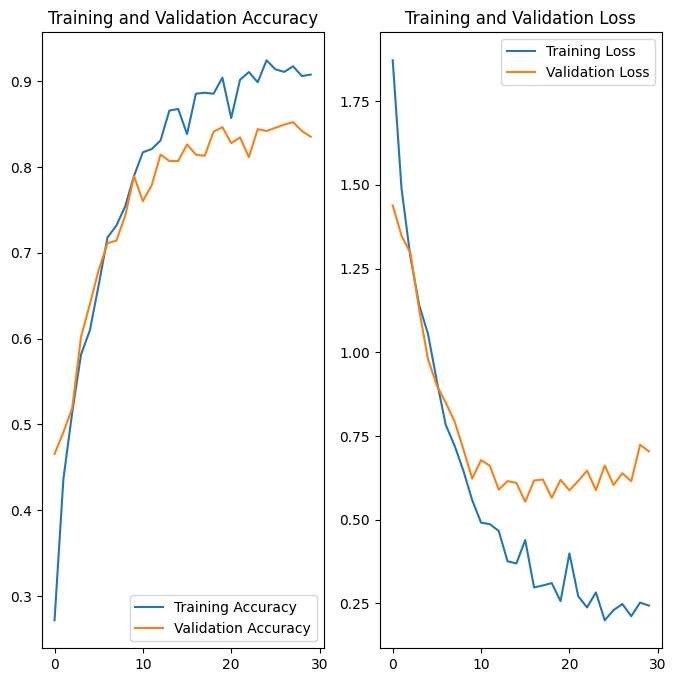

In [18]:
# Visualizing train result

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We have got a decent model with 90% accuracy on train data and 83% accuracy on validation data.

### Prediction

1/1 [==============================] - 0s 19ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


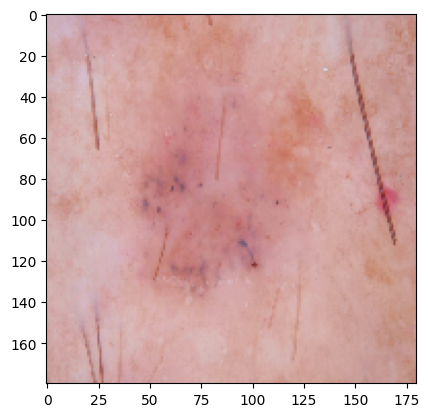

In [26]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model5.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )